In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_score

# Implementação da Extreme Learning Machine

Este exercício compreende a tarefa de implementar uma ELM simples, para que seja possível comprar com com os classificadores Perceptron e MLPClassifier da biblioteca scikit-learn.

Esta comparação será feita utilizando 4 bases de dados e ao final será mostrado uma tabela comparativa contendo estatísticas de cross validation para os 3 classificadores.

In [21]:
from scipy.linalg import pinv2
from scipy.special import expit
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin

class ELM(BaseEstimator, ClassifierMixin):

    def __init__(self, fator = 5):
        self.fator         = fator
        self.pesos_entrada = None
        self.pesos_saida   = None

    def computa_camada_oculta(self, X):
        #adiciona o bias ao vetor de entrada
        x_bias = np.hstack((np.ones((X.shape[0], 1)), X))
        oculta = np.matmul(x_bias, self.pesos_entrada)
        oculta = expit(oculta)
        return oculta

    def fit(self, X, y = None):
        
        if len(set(y)) > 2:
            y = LabelBinarizer().fit_transform(y)
        
        #adiciona o bias ao vetor de entrada
        x_bias = np.hstack((np.ones((X.shape[0], 1)), X))
        
        #calcula os pesos de entrada
        self.pesos_entrada = np.random.rand(x_bias.shape[1], x_bias.shape[1] * self.fator) * 2 - 1
        
        camada_oculta = self.calcula_camada_oculta(x_bias)
        self.pesos_saida = np.matmul(np.linalg.pinv(camada_oculta), y * 2 - 1)
    
    def predict(self, X, y=None):
        decisao = self.decision_function(X)
        if len(decisao.shape) > 1:
            decisao = np.argmax(decisao, axis = 1)
        else:
            decisao = decisao > 0
        return decisao

    #esta função deve ser interna
    #além disso, requer que os pesos de entrada tenham sido calculados pelo metodo fit
    def calcula_camada_oculta(self, x_bias):
        oculta = np.matmul(x_bias, self.pesos_entrada)
        oculta = expit(oculta)
        return oculta
    
    def decision_function(self, X):
        #adiciona o bias ao vetor de entrada
        x_bias = np.hstack((np.ones((X.shape[0],1)),X))
        
        #calcula camada oculta
        oculta = self.calcula_camada_oculta(x_bias)
        
        #retorna decisao
        decisao = np.matmul(oculta, self.pesos_saida)
        return np.tanh(decisao)

In [30]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles

X, y = make_classification(n_samples = 2000, n_features = 40, random_state = 42)
linearly_separable_teste_1 = (X, y)

X, y = make_classification(n_samples = 240, n_features = 250, random_state = 42)
linearly_separable_teste_2 = (X, y)

X, y = make_gaussian_quantiles(n_samples = 2000, n_features = 4, n_classes = 2, random_state = 42)
gaussian_separable_teste_1 = (X, y)

X, y = make_gaussian_quantiles(n_samples = 240, n_features = 250, n_classes = 2, random_state = 42)
gaussian_separable_teste_2 = (X, y)

datasets = [
    ("Base 1", linearly_separable_teste_1),
    ("Base 2", linearly_separable_teste_2),
    ("Base 3", gaussian_separable_teste_1),
    ("Base 4", gaussian_separable_teste_2)
]

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

classifiers = [
    ("ELM", ELM(15)),
    ("Perceptron", Perceptron()),
    ("MLPClassifier", MLPClassifier(alpha=1, max_iter=1000)),
]

## Plotagem

Nesta etapa, a entrada "X" de cada dataset, será transformada por um StandardScaler e também por um PCA, sendo que o PCA será iniciado com o parâmetro n_components igual a 2

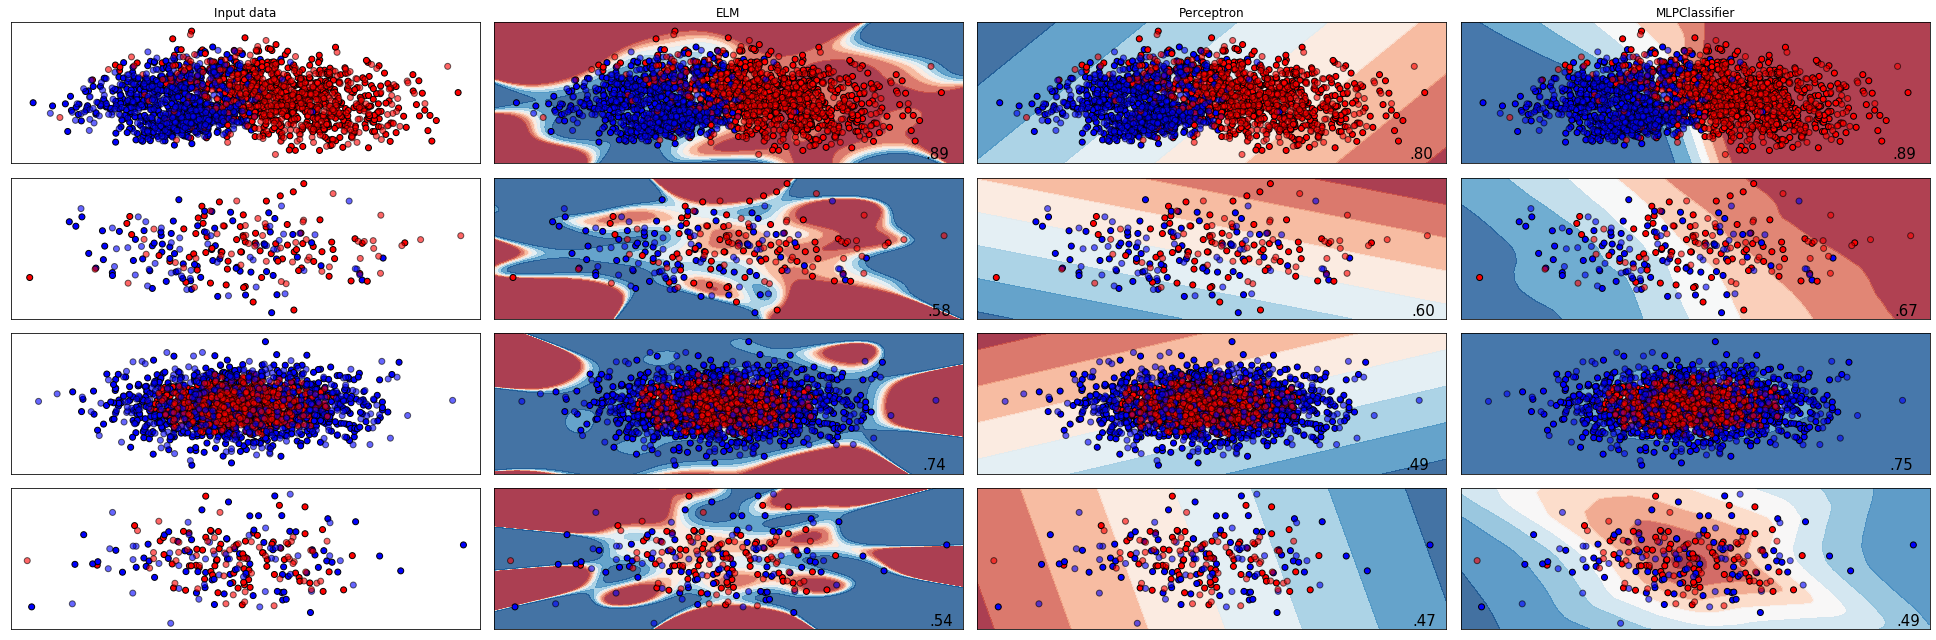

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

h = .02  # step size in the mesh
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
ds_cnt = 0
for dsn, ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    
    #passa a entrada pelo standard scaler
    X = StandardScaler().fit_transform(X)
    
    #após o standard scaler, passamos um PCA para pegar as duas características mais representativas
    X = PCA(n_components=2).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    
    if ds_cnt == 0:
        ax.set_title("Input data")
        
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for classifier in classifiers:
        name, clf = classifier
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
        
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1

    ds_cnt = +1
plt.tight_layout()
plt.show()

## Resultados e discussão da plotagem

Olhando os gráficos e tendo conheciment das bases que geraram esses gráficos, podemos chegar à conclusão que esses métodos classificadores funcionam melhor conforme o número de amostras, como podemos ver na primeira e na terceira linhas, onde o score foi geralmente melhor.

Nas bases das linhas 2 e 3, há poucas amostras. Com isso, vemos que os resultados foram menos satisfatórios, o que é relativamente esperado uma vez que os métodos de redes neurais necessitam de uma grande quantidade de dados para realizar o treinamento.

## Cross Validation  usando os classificadores e as bases

In [33]:
def evaluate(datasets, classifiers, use_pca = True):
    df = pd.DataFrame()
    df_stats = []
    index = []
    stat_exemplo = {"min": 0, "max": 0, "mean": 0, "median": 0, "std": 0, "fit-time": 0}
    columns = []
    subcolumns = []
    for dsn, ds in datasets:
        ds_stats = []
        index.append(dsn)
        # preprocess dataset, split into training and test part
        X, y = ds

        #passa a entrada pelo standard scaler
        X = StandardScaler().fit_transform(X)

        #após o standard scaler, caso o parametro use_pca esteja com valor True, passamos um PCA para pegar as duas características mais representativas
        if use_pca:
            X = PCA(n_components = 2).fit_transform(X)

        for classifier in classifiers:
            name, clf = classifier
            
            #inicia o timer
            inicio = time.time()

            #realiza o cross validation com 5 folds
            scores = cross_val_score(clf, X, y, cv=5)

            #obtém o tempo de cross validation
            duracao = time.time() - inicio

            stats = {"min": 0, "max": 0, "mean": 0, "median": 0, "std": 0, "fit-time": 0}

            stats["fit-time"] = duracao
            stats["max"]      = np.max(scores)
            stats["min"]      = np.min(scores)
            stats["mean"]     = np.mean(scores)
            stats["median"]   = np.median(scores)
            stats["std"]      = np.std(scores)

            for key in stats:
                ds_stats.append(stats[key])

        df_stats.append(ds_stats)


    for name, clf in zip(names, classifiers):
        columns.append(name)
    for key in stat_exemplo:
        subcolumns.append(key)

    header = pd.MultiIndex.from_product([columns, subcolumns], names=['classifier ->','statistics ->'])
    df = pd.DataFrame(df_stats, index = index, columns = header)
    return df

### Resultado do cross validation com PCA

In [35]:
df = evaluate(datasets, classifiers)
df

classifier ->       ELM                                                    \
statistics ->       min       max      mean    median       std  fit-time   
Base 1         0.862500  0.912500  0.894000  0.902500  0.018276  0.030001   
Base 2         0.562500  0.645833  0.595833  0.583333  0.028260  0.000000   
Base 3         0.747500  0.772500  0.762000  0.760000  0.008860  0.021001   
Base 4         0.520833  0.625000  0.558333  0.541667  0.040397  0.015625   

classifier -> Perceptron                                                    \
statistics ->        min       max      mean    median       std  fit-time   
Base 1          0.792500  0.900000  0.853000  0.862500  0.039414  0.012988   
Base 2          0.375000  0.625000  0.445833  0.416667  0.092796  0.015626   
Base 3          0.457500  0.542500  0.500500  0.502500  0.028036  0.011998   
Base 4          0.458333  0.520833  0.483333  0.479167  0.020412  0.000000   

classifier -> MLPClassifier                                                  
statistics ->           min       max    mean    median       std  fit-time  
Base 1               0.8550  0.907500  0.8895  0.897500  0.019326  3.667619  
Base 2               0.5625  0.729167  0.6625  0.687500  0.067700  0.486333  
Base 3               0.7475  0.762500  0.7555  0.755000  0.005339  4.371542  
Base 4               0.5000  0.625000  0.5875  0.604167  0.046398  0.578434

### Resultado do cross validation sem PCA

In [36]:
df = evaluate(datasets, classifiers, use_pca = False)
df

classifier ->     ELM                                                    \
statistics ->     min       max      mean    median       std  fit-time   
Base 1         0.7750  0.835000  0.806000  0.820000  0.025768  0.845708   
Base 2         0.6875  0.958333  0.816667  0.812500  0.086803  0.456000   
Base 3         0.9550  0.970000  0.966000  0.967500  0.005612  0.046876   
Base 4         0.4375  0.645833  0.541667  0.520833  0.069722  0.435420   

classifier -> Perceptron                                                    \
statistics ->        min       max      mean    median       std  fit-time   
Base 1          0.807500  0.867500  0.842000  0.840000  0.022439  0.013000   
Base 2          0.645833  0.895833  0.820833  0.854167  0.089946  0.010000   
Base 3          0.412500  0.547500  0.493000  0.525000  0.056577  0.015624   
Base 4          0.479167  0.583333  0.533333  0.520833  0.042898  0.015599   

classifier -> MLPClassifier                                                   
statistics ->           min     max      mean    median       std   fit-time  
Base 1             0.837500  0.8975  0.870000  0.877500  0.020125  10.875098  
Base 2             0.625000  0.8750  0.758333  0.729167  0.093727   2.984120  
Base 3             0.965000  0.9925  0.981000  0.982500  0.009028   9.125612  
Base 4             0.479167  0.6250  0.537500  0.500000  0.063738   2.845208

## Avaliação Final

Conforme o resultado já discutido na plotagem dos gráficos, os melhores resultados do cross validation com e sem PCA estão nas bases 1 e 3, devido ao grande número de amostras que estas bases possuem. 

### Com PCA
Se considerarmos a média (coluna "mean") dos dataframes, podemos observar que no geral a ELM teve um desempenho melhor que o Perceptron e o MLPClassifier para as bases 1 e 3, porém perdeu para o MLPClassifier nas bases 2 e 4.

Além disso, o tempo de fit (aqui é considerado o tempo de execução da função cross_val_score) da ELM foi bem abaixo do MLPClassifier, que foi o classificador mais lento neste experimento.

### Sem PCA
Se considerarmos a média (coluna "mean") dos dataframes, podemos observar que na base 3 o classificador Perceptron teve um desempenho muito abaixo da ELM e do MLPClassifier, ficando com cerca de metade da performance para esta base de dados quando comparado com os demais classificadores.

Na base 4, a ELM se saiu melhor que o Perceptron e o MLPClassifier, mas por pouco, enquanto que na base 1 a ELM teve um desempenho cerca de 4% pior que o Perceptron e 7% pior que o MLPClassifier. Na base 2 o MLPClassifier teve o pior resultado, ficando 6% abaixo da ELM.

Em todos os casos, novamente o MLPClassifier teve de longe o pior tempo de fit.